In [10]:
from import_src import import_src
import_src()

Append /home/ubuntu/khiempm/MLOpsVN/src to sys.path


In [11]:
import mlflow
from mlflow.entities import ViewType
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os 
import json
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, f1_score, roc_auc_score, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from utils import AppConfig
import warnings
warnings.filterwarnings("ignore")

In [4]:
mlflow.set_tracking_uri(AppConfig.MLFLOW_TRACKING_URI)

In [5]:
mlflow.search_experiments(filter_string="attribute.name LIKE 'phase-2_prob-2_%'")[0].experiment_id

'5'

In [6]:
client = mlflow.tracking.MlflowClient(tracking_uri=AppConfig.MLFLOW_TRACKING_URI)
search = client.search_runs(experiment_ids='5', order_by=["metrics.validation_name DESC"], max_results=1)[0]

In [8]:
search.to_dictionary()['info']

{'artifact_uri': 'mlflow-artifacts:/5/9994bb97b7c34b629cc34e4480783d9d/artifacts',
 'end_time': 1688714842048,
 'experiment_id': '5',
 'lifecycle_stage': 'active',
 'run_id': '9994bb97b7c34b629cc34e4480783d9d',
 'run_name': 'blushing-skink-36',
 'run_uuid': '9994bb97b7c34b629cc34e4480783d9d',
 'start_time': 1688714840189,
 'status': 'FINISHED',
 'user_id': 'ubuntu'}

In [9]:
model_uri = f"runs:/{search.to_dictionary()['info']['run_id']}/model"
mlflow.sklearn.load_model(model_uri)

LGBMClassifier(colsample_bytree=0.7117540089599735, max_depth=15, metric=None,
               n_estimators=10000, num_leaves=24, subsample=0.741377736830994,
               verbose=0)

In [53]:
os.path.join("models:/", "eheee")
        

'models:/eheee'

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
link_raw_data_1 = f"../../data/raw_data/phase-2/prob-1/raw_train.parquet"
link_raw_data_2 = f"../../data/raw_data/phase-2/prob-2/raw_train.parquet"

In [5]:
df_1 = pd.read_parquet(link_raw_data_1)
df_2 = pd.read_parquet(link_raw_data_2)

In [6]:
list_eliminate = []
for each in df_2.columns.tolist():
    sum_ = sum(df_1[each].values == 0)
    print(f"{each} {sum_}", end = " - ")
    if sum_ > 40000 and each != 'label':
        list_eliminate.append(each)


feature1 841 - feature2 0 - feature3 0 - feature4 0 - feature5 0 - feature6 28807 - feature7 0 - feature8 28807 - feature9 972 - feature10 28834 - feature11 929 - feature12 28808 - feature13 32282 - feature14 33016 - feature15 187 - feature16 28809 - feature17 30408 - feature18 32398 - feature19 32254 - feature20 32854 - feature21 32855 - feature22 32857 - feature23 32922 - feature24 32922 - feature25 32928 - feature26 0 - feature27 28807 - feature28 55686 - feature29 57699 - feature30 0 - feature31 13877 - feature32 0 - feature33 0 - feature34 0 - feature35 0 - feature36 61124 - feature37 61124 - feature38 55686 - feature39 0 - feature40 0 - feature41 60982 - label 22390 - 

In [7]:
list_eliminate

['feature28', 'feature29', 'feature36', 'feature37', 'feature38', 'feature41']

In [8]:
df_2['label'].value_counts()

Normal                   22390
Other                    13963
Exploits                 10864
Denial of Service         9585
Information Gathering     4081
Malware                    958
Name: label, dtype: int64

In [12]:
link_train_data_2 = f"../../data/train_data/phase-2/prob-2/train_x.parquet"
link_ytrain_data_2 = f"../../data/train_data/phase-2/prob-2/train_y.parquet"
link_test_data_2 = f"../../data/train_data/phase-2/prob-2/test_x.parquet"
link_ytest_data_2 = f"../../data/train_data/phase-2/prob-2/test_y.parquet"

link_ytrain_data_1 = f"../../data/train_data/phase-2/prob-1/train_y.parquet"
link_ytest_data_1 = f"../../data/train_data/phase-2/prob-1/test_y.parquet"


In [14]:
train_x = pd.read_parquet(link_train_data_2)
train_y = pd.read_parquet(link_ytrain_data_2)

test_x = pd.read_parquet(link_test_data_2)
test_y = pd.read_parquet(link_ytest_data_2)

train_y_2 = pd.read_parquet(link_ytrain_data_1)
test_y_2 = pd.read_parquet(link_ytest_data_1)

In [15]:
# eliminated_columns = list_eliminate
eliminated_columns = []

In [16]:
X_train = train_x.drop(columns=eliminated_columns)
X_test = test_x.drop(columns=eliminated_columns)

X_train['label'] = train_y
X_test['label'] = test_y

In [19]:
feature_group = X_train.columns.tolist()
X_train['label'].value_counts()

Normal                   17184
Exploits                  5422
Denial of Service         4649
Other                     3792
Information Gathering     1895
Malware                    395
Name: label, dtype: int64

In [13]:
def group_mean_columns(ret_df, df, list_col, target_col):
    dict_query = {each: "mean" for each in list_col}
    dict_rename = {each: f"{each}_mean_{target_col}" for each in list_col}

    df_agg = df.groupby(target_col).agg(dict_query).reset_index()
    df_agg = df_agg.rename(columns=dict_rename)
    return ret_df.merge(df_agg, how="inner", on=target_col)

In [14]:
feature_imp = ["feature1", "feature5", "feature6", "feature7", "feature8", "feature35", "feature40"]
# X_train = group_mean_columns(X_train, X_train, feature_imp, "feature3")
# X_test = group_mean_columns(X_test, X_train, feature_imp, "feature3")

# X_train = group_mean_columns(X_train, X_train, feature_imp, "feature2")
# X_test = group_mean_columns(X_test, X_train, feature_imp, "feature2")

In [15]:
# X_train = X_train[X_train['label'].isin(['Denial of Service', 'Exploits'])]
# X_test = X_test[X_test['label'].isin(['Denial of Service', 'Exploits'])]

In [16]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [17]:
category_columns =  ["feature2", "feature3", "feature4"] 

In [58]:
def remove_dup_absolutely_records(X_train, target_col, type_remove=0):
    feature_group = X_train.columns.tolist()
    dup_ = X_train.groupby(feature_group).agg(count_per_label=(target_col, "count")).reset_index()
    feature_group.remove(target_col)
    count_record = X_train.groupby(feature_group).agg(count_distinct_label=(target_col, "nunique")).reset_index()
    dup_['order'] = dup_.sort_values(['count_per_label', target_col], ascending=[False, False]).groupby(feature_group).cumcount()
    dup_['count_per_label_lag'] = dup_.sort_values(['order']).groupby(feature_group)['count_per_label'].shift(-1)
    dup_ = dup_.merge(count_record, how='inner', on=feature_group)
    if type_remove == 0:
        dup_ = dup_[(dup_["order"] == 0) & (dup_["count_distinct_label"] == 1)]
    else:
        dup_ = dup_[(dup_["order"] == 0) & ((dup_["count_distinct_label"] == 1) | ((dup_["count_per_label"]) != (dup_["count_per_label_lag"])))]
    dup_ = dup_.drop(columns = ["count_per_label", "order", "count_per_label_lag", "count_distinct_label"])
    return dup_

In [59]:
X_train_1 = remove_dup_absolutely_records(X_train, 'label')
X_train_2 = remove_dup_absolutely_records(X_train, 'label', type_remove=1)

In [62]:
X_train_2["label"].value_counts()

Normal                   17273
Exploits                  6046
Denial of Service         5178
Other                     4328
Information Gathering     1962
Malware                    405
Name: label, dtype: int64

In [63]:
X_train["label"].value_counts()

Normal                   17912
Other                    11170
Exploits                  8691
Denial of Service         7668
Information Gathering     3265
Malware                    766
Name: label, dtype: int64

In [40]:
def change_dup_records(X_train):
    feature_group = X_train.columns.tolist()
    dup_ = X_train.groupby(feature_group)['label'].size().unstack(fill_value=0).reset_index()
    res = ["Denial of Service", "Exploits", "Information Gathering", "Malware", "Normal", "Other"]
    def get_label(doc, ex, ig, ml, norm, other):
        arr_ = [doc, ex, ig, ml, norm, other]
        idx_res = np.argmax(arr_)
        return res[idx_res]

    dup_["label_final"] = dup_.apply(lambda x: get_label(x["Denial of Service"], x["Exploits"], x["Information Gathering"], x["Malware"], x["Normal"], x["Other"]), axis=1)
    dup_ = dup_.drop(columns=res)
    feature_join = feature_group.copy()
    feature_join.remove("label")
    X_train_final = X_train.merge(dup_, how = "inner", on=feature_join)
    X_train_final = X_train_final[X_train_final["label"] == X_train_final["label_final"]].reset_index(drop=True)
    X_train_final = X_train_final.drop(columns=["label"])
    X_train_final = X_train_final.rename(columns = {"label_final": "label"})
    return X_train_final


def remove_dup_relatively_records(X_train):
    feature_group = X_train.columns.tolist()
    feature_group.remove("label")
    dup_ = X_train.groupby(feature_group).agg(nunique_label=("label", "nunique")).reset_index()
    X_train_final = X_train.merge(dup_, how = "inner", on=feature_group)
    X_train_final = X_train_final[X_train_final["nunique_label"] == 1].reset_index(drop=True)
    X_train_final = X_train_final.drop(columns=["nunique_label"])
    return X_train_final

In [103]:
# X_train_final = remove_dup_records(X_train.copy())
# X_test_final = remove_dup_records(X_test.copy())


In [104]:
lbe = LabelEncoder().fit(X_train_final['label'])
train_y = lbe.transform(X_train_final['label'])
test_y = lbe.transform(X_test_final['label'])
X_train_final = X_train_final.drop(columns=["label"])
X_test_final = X_test_final.drop(columns=["label"])

In [105]:
param_grid = {"max_depth": 10, "n_estimators": 3000, "num_leaves": 12, "reg_alpha": 1, "reg_lambda": 0.5}
model_ = LGBMClassifier(metric=None, **param_grid, verbose=0)
model_.fit(X_train_final, train_y, eval_set=(X_test_final, test_y), eval_metric="multi_logloss", 
                 categorical_feature=category_columns, early_stopping_rounds=300, verbose=0)  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

LGBMClassifier(max_depth=10, metric=None, n_estimators=3000, num_leaves=12,
               reg_alpha=1, reg_lambda=0.5, verbose=0)

In [106]:
accuracy_score(test_y, model_.predict(X_test_final))

0.8988444781208562

In [52]:
# feature_imp = dict(zip(reg.feature_names_in_, reg.feature_importances_))
# feature_imp = pd.DataFrame(data={"col": list(feature_imp.keys()), "imp": list(feature_imp.values())})
# feature_imp.sort_values(by=['imp'], ascending=False).head(10)

,col,imp
39,feature40,0.097812
8,feature9,0.094719
7,feature8,0.079807
2,feature3,0.075404
29,feature30,0.064825
6,feature7,0.056753
25,feature26,0.051458
13,feature14,0.043556
26,feature27,0.040556
34,feature35,0.032627


In [1]:
# 726 / (338 + 14 + 23 + 431 + 2 + 726)
# 1526 / (1526 + 178 + 38 + 11 + 54 + 6)

0.47327249022164275

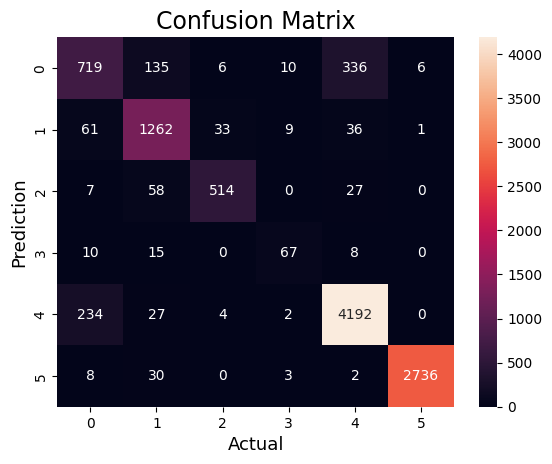

In [107]:
cm = confusion_matrix(test_y, model_.predict(X_test_final))
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [108]:
lbe = LabelEncoder().fit(X_train['label'])
train_y = lbe.transform(X_train['label'])
test_y = lbe.transform(X_test['label'])
X_train = X_train.drop(columns=["label"])
X_test = X_test.drop(columns=["label"])

In [109]:
param_grid = {"max_depth": 10, "n_estimators": 3000, "num_leaves": 15, "reg_alpha": 1, "reg_lambda": 0.5}
model_multilclass = LGBMClassifier(metric=None, **param_grid, verbose=0)
model_multilclass.fit(X_train, train_y, eval_set=(X_test, test_y), eval_metric="multi_logloss", 
                      categorical_feature=category_columns, early_stopping_rounds=300, verbose=0)  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

LGBMClassifier(max_depth=10, metric=None, n_estimators=3000, num_leaves=15,
               reg_alpha=1, reg_lambda=0.5, verbose=0)

In [110]:
accuracy_score(test_y, model_multilclass.predict(X_test))

0.8937298730820231

In [85]:
np.set_printoptions(precision=3)
data_ = model_multilclass.predict_proba(X_test).astype('float32')
pred = pd.DataFrame(data=data_, columns=['Denial of Service', 'Exploits', 'Information Gathering', 'Malware', 'Normal', 'Other'])
pred["label"] = test_y

In [87]:
pred[pred["label"] == 0]

,Denial of Service,Exploits,Information Gathering,Malware,Normal,Other,label
0,0.007892,0.025219,0.001089,0.963319,0.001884,0.000597,0
1,0.610839,0.271073,0.000482,0.000464,0.109349,0.007793,0
7,0.376874,0.013501,0.000618,0.002628,0.599020,0.007359,0
9,0.728766,0.042370,0.002701,0.001003,0.224102,0.001057,0
17,0.783531,0.044139,0.001625,0.000979,0.169286,0.000440,0
...,...,...,...,...,...,...,...
12349,0.024047,0.971296,0.000221,0.000294,0.001667,0.002474,0
12356,0.029754,0.966735,0.000360,0.000505,0.001431,0.001215,0
12364,0.033165,0.043368,0.905026,0.000711,0.007247,0.010483,0
12365,0.033165,0.043368,0.905026,0.000711,0.007247,0.010483,0


In [44]:
# 889 / (889 + 531 + 11 + 21 + 428 + 3)
1733 / (1733 + 323 + 35 + 14 + 59 + 5)

0.7989857076994007

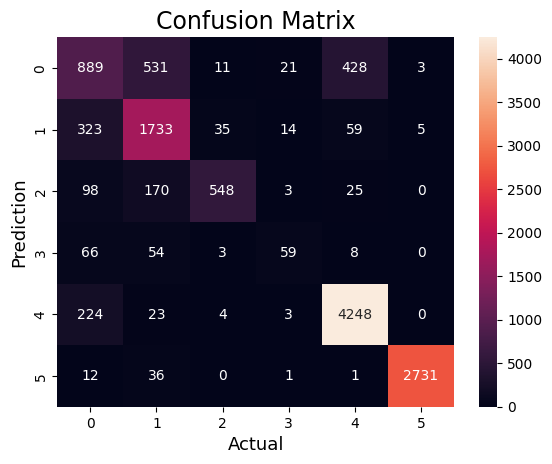

In [48]:
cm = confusion_matrix(test_y, model_multilclass.predict(X_test))
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
 

In [35]:
print(np.unique(test_y))
print(lbe.inverse_transform(np.unique(test_y)))

[0 1 2 3 4 5]
['Denial of Service' 'Exploits' 'Information Gathering' 'Malware' 'Normal'
 'Other']


In [39]:
feature_imp = dict(zip(model_multilclass.feature_name_, model_multilclass.feature_importances_))
feature_imp = pd.DataFrame(data={"col": list(feature_imp.keys()), "imp": list(feature_imp.values())})

In [41]:
feature_imp.sort_values(by=['imp'], ascending=False)
#feature_imp = ["feature26", "feature7", "feature11", "feature1", "feature35"]

,col,imp
25,feature26,1427
6,feature7,1301
10,feature11,646
1,feature2,618
0,feature1,574
34,feature35,559
29,feature30,530
26,feature27,527
19,feature20,505
39,feature40,499


In [43]:
error_analysis = train_x.copy()
error_analysis['label'] = train_y

In [147]:
error_analysis.groupby('label').mean()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41
label,,,,,,,,,,,,,,,,,,,,,
0,2.421133,104.763828,0.537523,3.523111,16.234355,13.398987,9325.515840,11055.516879,243.860166,117.348221,...,2.514542,2.168138,1.718774,4.522592,0.003765,0.003765,0.079330,3.848741,5.041807,0.00000
1,2.186818,103.486026,2.666130,3.359172,29.009546,22.489822,22930.753422,17808.931570,173.815756,154.929155,...,1.976078,1.555032,1.510983,2.916389,0.037148,0.037148,0.253479,3.408741,2.727660,0.00000
2,1.198596,107.645351,0.837195,3.540315,7.314180,6.808156,920.083102,4626.364535,245.739883,114.739574,...,1.870559,1.505715,1.466172,2.537535,0.000000,0.000000,0.333024,2.991350,2.667593,0.00000
3,1.473506,102.135417,0.296875,3.664062,6.558594,3.093750,1033.937500,1380.065104,250.177083,75.578125,...,2.207031,1.902344,1.894531,3.305990,0.000000,0.000000,0.055990,3.588542,4.006510,0.00000
4,1.031961,109.198457,1.351912,2.760063,27.570271,33.004081,4308.609403,26301.266492,95.092297,82.432581,...,3.430680,1.766827,1.149374,3.879472,0.012914,0.012970,0.146467,3.976576,5.509504,0.03807
5,0.042469,117.754427,2.007154,3.981667,2.593811,0.834913,578.698981,876.672331,252.660705,3.935253,...,17.135396,16.928814,12.966643,24.137274,0.000000,0.000000,0.007244,17.285906,24.773565,0.00000


In [181]:
error_analysis[['feature8', 'label']]

,feature8,label
0,0.0,1
1,0.0,5
2,354.0,2
3,0.0,5
4,0.0,5
...,...,...
49467,0.0,0
49468,0.0,2
49469,48710.0,4
49470,86.0,4


In [24]:
list_eliminate

['feature6',
 'feature8',
 'feature10',
 'feature12',
 'feature13',
 'feature14',
 'feature16',
 'feature17',
 'feature18',
 'feature19',
 'feature20',
 'feature21',
 'feature22',
 'feature23',
 'feature24',
 'feature25',
 'feature27',
 'feature28',
 'feature29',
 'feature36',
 'feature37',
 'feature38',
 'feature41']